# From Ground Motion to Digital "Counts" 

Raw digital seismic data is generally in units called "counts". A seismometer generates a voltage roughly proportional to the ground motion velocity, but it is not perfect. 

accelerometers record ground motion acceleration, and an infrasound sensor records differential air pressure, An analog-to-digital converter (ADC) turns an input voltage into 

This notebook explains **why a seismic digitizer has its own impulse / frequency response** (it is not a perfect voltmeter), and shows how to **plot poles & zeros in the z-plane** using metadata (StationXML/RESP).

It also includes a short **Centaur (Nanometrics CTR4 series) datasheet summary** you can use as a concrete example of the digitizer functions that create a response.


In [ ]:
from flovopy.stationmetadata.sensors import get_rs3d_v5 #, _fetch_and_parse_response
sta = "SHAKE"
loc = "00"
get_rs3d_v5(sta, loc)


## 1) Big picture: what the digitizer does to the signal

A typical chain is:

**ground motion → sensor → preamp / input stage → anti-alias analog filter → ADC (sample & hold + quantization) → digital decimation filters → stored/streamed counts**

From an LTI (linear time-invariant) perspective, the digitizer contributes its own transfer function:

$$
H_{\text{total}}(f) = H_{\text{sensor}}(f)\,H_{\text{digitizer}}(f)
$$

and

$$
H_{\text{digitizer}}(f)
= H_{\text{analog front-end}}(f)\,
  H_{\text{anti-alias}}(f)\,
  H_{\text{S\&H}}(f)\,
  H_{\text{decimation}}(f)
$$


So the digitizer **does have an impulse response** (in fact, multiple filtering stages define it).



## 2) Why it *looks* “faithful” in practice (but isn’t perfect)

Digitizers are engineered so that within the intended passband:

- amplitude response is very flat
- distortion is low
- linearity is high

…but **near Nyquist**, at **very low frequencies**, and in **phase/group delay**, the filtering is real and measurable.

Operationally, this is why response correction (`remove_response`) needs both:
- sensor response (poles & zeros)
- digitizer stages (gain + analog filters + FIR decimation, etc.)



## 3) Centaur datasheet example: clues that the digitizer has a response

The Centaur datasheet explicitly describes internal filtering and DSP features that imply a non-trivial response, including:

- **Decimation anti-aliasing filter** with selectable **linear phase (noncausal)** or **minimum phase (causal)**
- very high attenuation at Nyquist (e.g., -140 dB linear phase)
- **user-configurable** low-pass and high-pass digital filters (1st–5th order)
- wide range of sample rates (up to 5000 sps) and gains

These features are great for data quality and flexibility—but they necessarily define an impulse response.


# NRL Responses: Sensor, Digitizer, and Combined (Time + Frequency Domains)

We will download nominal responses from the IRIS/EarthScope Nominal Response Library (NRL) using ObsPy:

- **Sensor:** Nanometrics Trillium Compact 120 (Vault, Posthole, OBS), 754 V/m/s  
- **Digitizer:** Nanometrics Centaur, 40 Vpp, linear phase, 100 sps  
- **Combined:** cascaded sensor + digitizer stages

We will visualize each response:
- **Frequency domain:** magnitude and phase of the complex response \(H(f)\)
- **Time domain:** impulse response \(h(t)\) obtained by inverse-FFT of \(H(f)\)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.nrl import NRL

nrl = NRL()

sensor_keys = ["Nanometrics", "Trillium Compact 120 (Vault, Posthole, OBS)", "754 V/m/s"]
datalogger_keys = ["Nanometrics", "Centaur", "40 Vpp (1)", "Off", "Linear phase", "100"]

# --- sensor-only ---
resp_sensor, sensor_type = nrl._get_response("sensors", keys=sensor_keys)

# --- digitizer-only ---
resp_digitizer, dl_type = nrl._get_response("dataloggers", keys=datalogger_keys)

# --- combined ---
resp_combined = nrl.get_response(datalogger_keys=datalogger_keys, sensor_keys=sensor_keys)

print("Sensor response:", resp_sensor)
print("Digitizer response:", resp_digitizer)
print("Combined response:", resp_combined)


Sensor response: Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 754.3 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 754.3
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1
Digitizer response: Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 400000 defined at 1.000 Hz
	6 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1
		Stage 2: PolesZerosResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 400000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
Combined response: Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 3.0172e+08 def

/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_40544/1842488692.py:5: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


## Helper plotting functions

ObsPy `Response.get_evalresp_response()` evaluates the complex response \(H(f)\) on a frequency grid.

From \(H(f)\), we plot:
- magnitude (in dB)
- phase (unwrapped, radians)

For “time domain,” we compute an **impulse response** via inverse FFT:
\[
h(t) = \mathcal{F}^{-1}\{H(f)\}
\]
This is the cleanest way to include **FIR decimation** stages (common in digitizers), which do not have poles/zeros.


In [27]:
def eval_response(resp, nfft=16384, fs=200.0, output="VEL"):
    """
    Evaluate complex response H(f) on an FFT-like grid up to Nyquist.

    resp: ObsPy Response
    fs: chosen evaluation sample rate (for plotting only)
    output: "DISP", "VEL", or "ACC" (what response is *to be expressed as*)
    """
    # Frequency grid: avoid f=0 for stability in log plots
    f = np.linspace(0.001, fs/2, nfft//2, endpoint=True)
    # ObsPy expects frequencies in Hz
    H = resp.get_evalresp_response(t_samp=1/fs, nfft=nfft, output=output, frequency=f)
    return f, H

def plot_mag_phase(f, H, title="", fmin=None, fmax=None):
    mag_db = 20*np.log10(np.maximum(np.abs(H), 1e-20))
    phase = np.unwrap(np.angle(H))

    fig, ax = plt.subplots(figsize=(11, 3))
    ax.plot(f, mag_db)
    ax.set_title(f"{title} — Magnitude")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude (dB)")
    ax.grid(True, alpha=0.3)
    if fmin is not None or fmax is not None:
        ax.set_xlim(left=fmin if fmin is not None else ax.get_xlim()[0],
                    right=fmax if fmax is not None else ax.get_xlim()[1])
    plt.show()

    fig, ax = plt.subplots(figsize=(11, 3))
    ax.plot(f, phase)
    ax.set_title(f"{title} — Phase (unwrapped)")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Phase (rad)")
    ax.grid(True, alpha=0.3)
    if fmin is not None or fmax is not None:
        ax.set_xlim(left=fmin if fmin is not None else ax.get_xlim()[0],
                    right=fmax if fmax is not None else ax.get_xlim()[1])
    plt.show()

def impulse_response_from_H(f, H, fs, n_time=4096):
    """
    Build an impulse response from complex H(f) using an rFFT grid.

    We interpolate H onto the exact rFFT frequency bins for numerical IFFT.
    """
    nfft = int(2**np.ceil(np.log2(n_time)))
    fr = np.fft.rfftfreq(nfft, d=1/fs)

    # Interpolate real and imag parts separately
    Hr = np.interp(fr, f, np.real(H), left=np.real(H[0]), right=np.real(H[-1]))
    Hi = np.interp(fr, f, np.imag(H), left=np.imag(H[0]), right=np.imag(H[-1]))
    Hri = Hr + 1j*Hi

    h = np.fft.irfft(Hri, n=nfft)
    t = np.arange(nfft) / fs
    return t, h

def plot_impulse(t, h, title="", tmax=None):
    fig, ax = plt.subplots(figsize=(11, 3))
    ax.plot(t, h)
    ax.set_title(f"{title} — Impulse response (time domain)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("h(t)")
    ax.grid(True, alpha=0.3)
    if tmax is not None:
        ax.set_xlim(0, tmax)
    plt.show()


## Choose an evaluation sample rate (for plotting)

To compare sensor/digitizer/combined responses on the same grid, we choose an evaluation sample rate `fs_eval`.

This does **not** change the response metadata. It only controls:
- Nyquist frequency shown in the plots
- time sampling of the derived impulse response


/Users/thompsong/miniconda3/envs/flovopy_plus/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/thompsong/miniconda3/envs/flovopy_plus/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


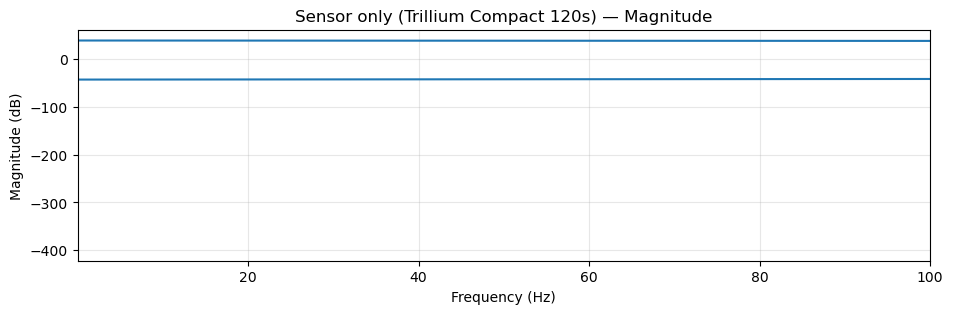

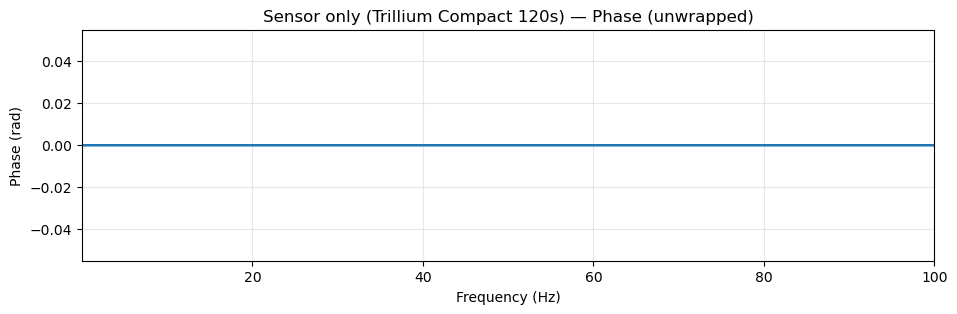

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

In [32]:
fs_eval = 200.0     # plotting grid only (Hz)
nfft = 32768
output = "VEL"      # typical for broadband seismometers

import numpy as np

def eval_response(resp, fs=200.0, nfft=32768, output="VEL"):
    """
    Evaluate complex response H(f) on a frequency grid up to Nyquist fs/2.

    Works across ObsPy versions that differ in get_evalresp_response() signature.
    """
    f = np.linspace(0.001, fs/2, nfft//2, endpoint=True)

    # Try the most common signatures in order.
    # Newer: get_evalresp_response(t_samp, nfft, output=..., frequency=...)
    try:
        H = resp.get_evalresp_response(t_samp=1/fs, nfft=nfft, output=output, frequency=f)
        return f, H
    except TypeError:
        pass

    # Some versions use frequencies=
    try:
        H = resp.get_evalresp_response(t_samp=1/fs, nfft=nfft, output=output, frequencies=f)
        return f, H
    except TypeError:
        pass

    # Older: might use freq=
    try:
        H = resp.get_evalresp_response(t_samp=1/fs, nfft=nfft, output=output, freq=f)
        return f, H
    except TypeError:
        pass

    # Oldest / fallback: no explicit frequency grid supported; returns
    # (freqs, resp) or just resp on internal grid.
    out = resp.get_evalresp_response(t_samp=1/fs, nfft=nfft, output=output)

    # Handle possible return types
    if isinstance(out, tuple) and len(out) == 2:
        f_out, H_out = out
        return np.asarray(f_out), np.asarray(H_out)

    # If it returned only H on an implicit FFT grid:
    H_out = np.asarray(out)
    # Guess grid: rfft-like from 0..Nyquist with nfft points
    f_out = np.fft.rfftfreq(nfft, d=1/fs)
    # Match lengths safely
    m = min(len(f_out), len(H_out))
    return f_out[:m], H_out[:m]


# SENSOR
f_s, H_s = eval_response(resp_sensor, nfft=nfft, fs=fs_eval, output=output)
plot_mag_phase(f_s, H_s, title="Sensor only (Trillium Compact 120s)", fmin=0.001, fmax=fs_eval/2)

t_s, h_s = impulse_response_from_H(f_s, H_s, fs=fs_eval, n_time=8192)
plot_impulse(t_s, h_s, title="Sensor only (Trillium Compact 120s)", tmax=30)


In [ ]:
# DIGITIZER
f_d, H_d = eval_response(resp_digitizer, nfft=nfft, fs=fs_eval, output=output)
plot_mag_phase(f_d, H_d, title="Digitizer only (Centaur)", fmin=0.001, fmax=fs_eval/2)

t_d, h_d = impulse_response_from_H(f_d, H_d, fs=fs_eval, n_time=8192)
plot_impulse(t_d, h_d, title="Digitizer only (Centaur)", tmax=5)


In [ ]:
# COMBINED
f_c, H_c = eval_response(resp_combined, nfft=nfft, fs=fs_eval, output=output)
plot_mag_phase(f_c, H_c, title="Combined (Trillium + Centaur)", fmin=0.001, fmax=fs_eval/2)

t_c, h_c = impulse_response_from_H(f_c, H_c, fs=fs_eval, n_time=8192)
plot_impulse(t_c, h_c, title="Combined (Trillium + Centaur)", tmax=30)


## Optional: Verify that Combined ≈ Sensor × Digitizer in frequency domain

In the frequency domain, cascaded stages multiply:
\[
H_\text{combined}(f) \approx H_\text{sensor}(f)\,H_\text{digitizer}(f)
\]

This should hold (within numerical tolerance) when evaluated on the same frequency grid.


In [ ]:
# Interpolate digitizer onto sensor grid and compare
Hd_interp = np.interp(f_s, f_d, np.real(H_d)) + 1j*np.interp(f_s, f_d, np.imag(H_d))
Hs = H_s
Hprod = Hs * Hd_interp

err = np.nanmax(np.abs(H_c - Hprod)) / np.nanmax(np.abs(H_c))
print(f"Max relative error (combined vs sensor*digitizer): {err:.3e}")

# Plot magnitude difference (dB)
mag_diff_db = 20*np.log10(np.maximum(np.abs(H_c),1e-20)) - 20*np.log10(np.maximum(np.abs(Hprod),1e-20))

plt.figure(figsize=(11,3))
plt.plot(f_s, mag_diff_db)
plt.title("Magnitude difference: combined - (sensor × digitizer)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Δ magnitude (dB)")
plt.grid(True, alpha=0.3)
plt.xlim(0.001, fs_eval/2)
plt.show()


## 4) Load a StationXML/RESP and inspect digitizer stages

In [ ]:
from obspy.clients.nrl import NRL

nrl = NRL()

def walk_keys(tree, prefix=None):
    prefix = prefix or []
    if isinstance(tree, dict):
        for k, v in tree.items():
            yield prefix + [k]
            yield from walk_keys(v, prefix + [k])



# Look at available manufacturers
print(nrl.sensors.keys())
print(nrl.dataloggers.keys())

'''
# Find paths containing "Trillium" (sensor)
for path in walk_keys(nrl.sensors):
    if any("Trillium" in p for p in path):
        print(path)

# Find paths containing "Centaur" (datalogger)
for path in walk_keys(nrl.dataloggers):
    if any("Centaur" in p for p in path):
        print(path)
'''

# Example: list Nanometrics sensors (may be nested)
#nan_sensors = nrl.sensors["Nanometrics"]['Trillium Compact 120 (Vault, Posthole, OBS)']['754 V/m/s']
#print(nan_sensors.keys())
resp_sensor = nrl.sensors["Nanometrics"]['Trillium Compact 120 (Vault, Posthole, OBS)']['754 V/m/s']
print(resp_sensor)

sensor_keys = ["Nanometrics", 'Trillium Compact 120 (Vault, Posthole, OBS)', '754 V/m/s']    # <- fill from your search above
datalogger_keys = ["Nanometrics", "Centaur", '40 Vpp (1)', 'Off', 'Linear phase', '100'] # <- fill from your search above

resp = nrl.get_response(sensor_keys=sensor_keys,
                        datalogger_keys=datalogger_keys)
print(resp)

# Example: list Nanometrics dataloggers
#resp_digitizer = nrl.dataloggers["Nanometrics"]["Centaur"]['40 Vpp (1)']['Off']['Linear phase']['100']
#print(resp_digitizer)



/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_40544/2547984636.py:3: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


dict_keys(['ASIR', 'CEA-DASE', 'Chaparral Physics', 'CME (now R-Sensors)', 'DTCC (manuafacturers of SmartSolo)', 'Eentec', 'EQMet', 'GaiaCode', 'Gem', 'GEObit', 'Geodevice', 'GEOsig', 'Geo Space/OYO', 'Geotech', 'Guralp', 'HGS Products', 'High Tech', 'Hyperion', 'IESE', 'iTem', 'Johnson Infrasound', 'Kinemetrics', 'LaHusen', 'Lennartz', 'Lunitek', 'Magseis Fairfield', 'Metrozet', 'Nanometrics', 'REF TEK', 'R-Sensors (previously listed as CME', 'RTClark', 'SARA', 'Seismo Wave', 'SensorNederland', 'Sercel/Mark Products', 'Silicon Audio', 'SolGeo', 'Sprengnether (now Eentec)', 'Streckeisen', 'Sunfull', 'TDG', 'Generic'])
dict_keys(['Agecodagis', 'CNSN', 'DAQ Systems (NetDAS)', 'DiGOS/Omnirecs', 'DTCC (manufacturers of SmartSolo', 'Earth Data', 'Eentec', 'EQMet', 'ESG', 'Gem', 'GEObit', 'Geodevice', 'GeoSIG', 'Geotech', 'Guralp', 'Kinemetrics', 'Lunitek', 'Magseis Fairfield', 'Nanometrics', 'Quanterra', 'REF TEK', 'R-Sensors', 'SARA', 'Seismic Source', 'SeismologyResearchCentre', 'Sercel',

In [5]:

# If you have a StationXML (or RESP) for a Centaur+sensor channel,
# you can inspect the response stages with ObsPy.

from obspy import read_inventory
import os
print(os.getcwd())

# --- USER: set this path to your StationXML file ---
# Example (Mac): xml_path = "/path/to/stationxml.xml"
xml_path = "../rs3d_v5.xml"

if xml_path:
    inv = read_inventory(xml_path)
    print(inv)

    # Pick a channel (first one as a default)
    net = inv[0].code
    sta = inv[0][0].code
    cha = inv[0][0][0].code
    loc = inv[0][0][0].location_code
    print(f"Example channel: {net}.{sta}.{loc}.{cha}")

    ch = inv[0][0][0]
    resp = ch.response
    print("\nResponse stages:")
    for stage in resp.response_stages:
        print(f"  Stage {stage.stage_sequence_number}: {stage.__class__.__name__}")
else:
    print("Set xml_path to your StationXML to run this section.")


/Users/thompsong/Developer/ComputationalSeismology/week2
Inventory created at 2026-01-21T20:53:14.886211Z
	Created by: ObsPy 1.4.2
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.4.2
	Contains:
		Networks (1):
			AM
		Stations (1):
			AM.R2199 (Raspberry Shake Personal Seismograph Station)
		Channels (3):
			AM.R2199..EHZ, AM.R2199..EHN, AM.R2199..EHE
Example channel: AM.R2199..EHE

Response stages:
  Stage 1: PolesZerosResponseStage
  Stage 2: CoefficientsTypeResponseStage


In [7]:
from obspy import read_inventory

#inv = read_inventory("stations.xml")

net = inv[0]
sta = net[0]
cha = sta[0]

# Loop through response stages and find a PolesZeros stage
paz_stage = None
for stage in cha.response.response_stages:
    if stage.__class__.__name__ == "PolesZerosResponseStage":
        paz_stage = stage
        break

if paz_stage is None:
    raise ValueError("No PolesZerosResponseStage found in this StationXML.")

zeros = paz_stage.zeros
poles = paz_stage.poles
gain  = paz_stage.stage_gain
norm  = paz_stage.normalization_factor

print("Zeros:", zeros)
print("Poles:", poles)
print("Stage gain:", gain)
print("Normalization:", norm)
print("Transfer function type:", paz_stage.pz_transfer_function_type)


Zeros: [0j, 0j, 0j]
Poles: [(-1+0j), (-3.03+0j), (-3.03+0j), (-666.67+0j)]
Stage gain: 360000000.0
Normalization: 673.959
Transfer function type: LAPLACE (RADIANS/SECOND)


In [10]:
paz = cha.response.get_paz()
print(paz)

print("Zeros:", paz["zeros"])
print("Poles:", paz["poles"])
print("Gain:", paz["gain"])
print("Sensitivity:", paz["sensitivity"])

Response type: PolesZerosResponseStage, Stage Sequence Number: 1
	From M/S (Velocity in Meters Per Second) to V (Volts)
	Stage gain: 360000000.0, defined at 5.00 Hz
	Transfer function type: LAPLACE (RADIANS/SECOND)
	Normalization factor: 673.959, Normalization frequency: 5.00 Hz
	Poles: (-1+0j), (-3.03+0j), (-3.03+0j), (-666.67+0j)
	Zeros: 0j, 0j, 0j


TypeError: 'PolesZerosResponseStage' object is not subscriptable

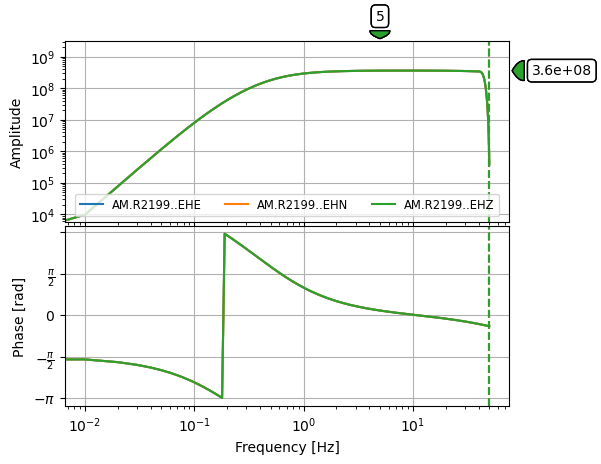

In [13]:


# Pick a channel
cha = inv[0][0][0]

# Plot overall response (choose output to match your channel meaning)
inv.plot_response(min_freq=0.01, output="VEL");   # try "DISP" and "ACC" too


## 5) Plot poles & zeros on the z-plane

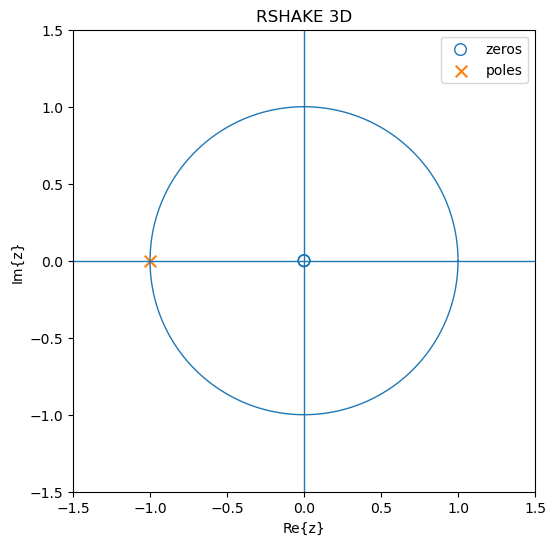

In [8]:

import numpy as np
import matplotlib.pyplot as plt

def plot_zplane(poles, zeros, title="Z-plane poles & zeros", ax=None):
    poles = np.asarray(poles, dtype=np.complex128)
    zeros = np.asarray(zeros, dtype=np.complex128)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 1000)
    ax.plot(np.cos(theta), np.sin(theta), linewidth=1)

    # Axes
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)

    # Poles (x) and zeros (o)
    if zeros.size:
        ax.scatter(zeros.real, zeros.imag, marker='o', s=70,
                   facecolors='none', edgecolors='C0', label='zeros')
    if poles.size:
        ax.scatter(poles.real, poles.imag, marker='x', s=70,
                   color='C1', label='poles')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Re{z}")
    ax.set_ylabel("Im{z}")
    ax.set_title(title)
    ax.legend(loc="best")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    plt.show()

def pz_from_stationxml_channel(channel):
    """Extract poles/zeros from the *first* PolesZerosResponseStage (if present)."""
    resp = channel.response
    for stage in resp.response_stages:
        if hasattr(stage, "poles") and hasattr(stage, "zeros"):
            return stage.poles, stage.zeros, stage
    return None, None, None

# --- Example 1: Demonstration poles/zeros (illustrative only) ---
# This is NOT a real Centaur response; it just demonstrates the plot.
demo_poles = [0.8 + 0.2j, 0.8 - 0.2j]
demo_zeros = [0.0 + 0.0j, 0.0 + 0.0j]

plot_zplane(poles, zeros, title="RSHAKE 3D")

# --- Example 2: If you loaded StationXML above, plot actual poles/zeros ---
# Uncomment and adapt once xml_path is set and inv is loaded.
#
# if xml_path:
#     ch = inv[0][0][0]
#     poles, zeros, stage = pz_from_stationxml_channel(ch)
#     if poles is None:
#         print("No poles/zeros stage found in this channel's response stages.")
#     else:
#         plot_zplane(poles, zeros, title=f"Poles & zeros from StationXML stage {stage.stage_sequence_number}")


## 6) Optional: plot magnitude/phase response from z-plane poles & zeros

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def freq_response_from_pz(poles, zeros, k=1.0, nfreq=4096):
    """Compute H(e^{jw}) on the unit circle from z-plane poles/zeros."""
    poles = np.asarray(poles, dtype=np.complex128)
    zeros = np.asarray(zeros, dtype=np.complex128)
    w = np.linspace(0, np.pi, nfreq)  # rad/sample
    z = np.exp(1j*w)

    num = np.ones_like(z, dtype=np.complex128) * k
    den = np.ones_like(z, dtype=np.complex128)

    for z0 in zeros:
        num *= (z - z0)
    for p0 in poles:
        den *= (z - p0)

    H = num / den
    return w, H

# Demo again (illustrative only)
w, H = freq_response_from_pz(demo_poles, demo_zeros, k=1.0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(w/np.pi, 20*np.log10(np.maximum(np.abs(H), 1e-20)))
ax.set_xlabel("Normalized frequency (× Nyquist)")
ax.set_ylabel("Magnitude (dB)")
ax.set_title("Magnitude response (illustrative example)")
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(w/np.pi, np.unwrap(np.angle(H)))
ax.set_xlabel("Normalized frequency (× Nyquist)")
ax.set_ylabel("Phase (rad)")
ax.set_title("Phase response (illustrative example)")
plt.show()



## 7) Centaur datasheet quick-reference (selected specs)

Use this as a checklist of "digitizer things that contribute to response":

- **Inputs**: 3 or 6 channels; differential input ranges; input impedance differs for standard vs high-gain.
- **Performance**: dynamic range specified at certain sample rates; selectable bit depth; gain options.
- **Filtering**: decimation anti-aliasing filter (linear or minimum phase); optional user high/low-pass filters.
- **Timing**: GNSS/PTP/NTP disciplined clock (not a filter, but matters for phase alignment).
- **Onboard processing**: STA/LTA detection and data product calculations (downstream of digitization).

For a quantitative response correction workflow, the most important thing is having a **complete StationXML/RESP** that includes:
- sensor PAZ stage(s)
- analog stages (if separately modeled)
- FIR decimation stages for each configured sample rate
- correct gains for each stage



## 8) Next steps (what to plug in for *your* Centaur)

1. Export a **StationXML** from the Centaur web interface or from your network metadata system.
2. Set `xml_path` in Section 4.
3. Identify which stage is sensor vs digitizer (often:
   - Stage 1: sensor PAZ
   - Later stages: analog/FIR/decimation/gain
4. Plot z-plane PZ (Section 5) and optionally magnitude/phase (Section 6).

If your StationXML encodes FIR stages (common), you can also plot the FIR impulse response directly.
